## Generación procedimental

Este cuaderno explorar como generar simulaciones procedimentalmente usando PyHelios y partiendo de una simulación base.

In [1]:
# Configurar entorno Jupyter
%config Completer.use_jedi = False

# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import time
from datetime import datetime

# Importar pyhelios
PYHELIOS_LIB_PATH = '/home/uadmin/git/helios/cmake-build-release'
HELIOS_PATH = '/home/uadmin/git/helios'
sys.path.append(PYHELIOS_LIB_PATH)
sys.path.append(HELIOS_PATH)
if os.getcwd().endswith('pyhelios'):
    os.chdir(os.path.dirname(os.getcwd()))
import pyhelios

### Plantilla XML para la simulación base

Para comenzar, se genera una plantilla XML representando la simulación base. Se utilizará la cadena de texto `<<<PARTES>>>` en el XML para ser sustituida por la descripción completa de la escena.

In [2]:
# Ruta al directorio temporal donde se exportarán los XML
tmpdir = os.path.join(os.getcwd(), 'tmpdir')
tmp_scene_xml = os.path.join(tmpdir, 'scene.xml')
tmp_survey_xml = os.path.join(tmpdir, 'survey.xml')
# XML de escena
SCENE_XML = \
'''
<?xml version="1.0" encoding="UTF-8"?>
<document>
<scene id="scene" name="scene">
    <part>
        <filter type="objloader">
            <param type="string" key="filepath" value="helios_asset/sceneparts/groundplane.obj" />
        </filter>
        <filter type="scale">
            <param type="double" key="scale" value="50" />
        </filter>
    </part>
<<<PARTES>>>
</scene>
</document>
'''
# XML de simulación
SURVEY_XML = \
f'''
<?xml version="1.0" encoding="UTF-8"?>
<document>
<survey name="trigal_procedimental" scene="{tmp_scene_xml}#scene" platform="helios_asset/platforms.xml#tractor" scanner="helios_asset/scanners_tls.xml#riegl_vz400">
    <leg>
        <platformSettings  x="-10" y="-10" z="0" onGround="true" movePerSec_m="3"/>
        <scannerSettings  active="true" pulseFreq_hz="100000" scanAngle_deg="20" scanFreq_hz="50" headRotatePerSec_deg="0.00" headRotateStart_deg="0.00" headRotateStop_deg="0.00" trajectoryTimeInterval_s="0.05"/>
    </leg>

    <leg>
        <platformSettings  x="10" y="-10" z="0" onGround="true" movePerSec_m="3"/>
        <scannerSettings  active="true" pulseFreq_hz="100000" scanAngle_deg="20" scanFreq_hz="50" headRotatePerSec_deg="0.00" headRotateStart_deg="0.00" headRotateStop_deg="0.00" trajectoryTimeInterval_s="0.05"/>
    </leg>

    <leg>
        <platformSettings  x="10" y="10" z="0" onGround="true" movePerSec_m="3"/>
        <scannerSettings  active="true" pulseFreq_hz="100000" scanAngle_deg="20" scanFreq_hz="50" headRotatePerSec_deg="0.00" headRotateStart_deg="0.00" headRotateStop_deg="0.00" trajectoryTimeInterval_s="0.05"/>
    </leg>

    <leg>
        <platformSettings  x="-10" y="10" z="0" onGround="true" movePerSec_m="3"/>
        <scannerSettings  active="true" pulseFreq_hz="100000" scanAngle_deg="20" scanFreq_hz="50" headRotatePerSec_deg="0.00" headRotateStart_deg="0.00" headRotateStop_deg="0.00" trajectoryTimeInterval_s="0.05"/>
    </leg>

    <leg>
        <platformSettings  x="-10" y="-10" z="0" onGround="true" movePerSec_m="3"/>
        <scannerSettings  active="false" pulseFreq_hz="100000" scanAngle_deg="20" scanFreq_hz="50" headRotatePerSec_deg="0.00" headRotateStart_deg="0.00" headRotateStop_deg="0.00" trajectoryTimeInterval_s="0.05"/>
    </leg>
</survey>
</document>
'''

### Generacíón procedimental

A continuación, se generarán 6 plantas de trigo procedimentalmente. La primera de ellas estará en el punto $(0, 0)$. Las cinco siguientes estarán colocadas en un círculo de radio $3$ metros centrado en el punto $(0, 0)$. Todas las plantas estarán escaladas al doble del tamaño original de la malla. 

In [3]:
# Generar 5 plantas de trigo en un círculo de radio 3 metros y una sexta planta en el centro
partes_xml = \
'''        <part>
            <filter type="objloader">
                <param type="string" key="filepath" value="helios_asset/sceneparts/wheat.obj" />
            </filter>
            <filter type="rotate">
                <param type="rotation" key="rotation">
                    <rot axis="x" angle_deg="90" />
                </param>
            </filter>
            <filter type="scale">
                <param type="double" key="scale" value="2" />
            </filter>
        </part>
'''
theta = np.linspace(-np.pi, np.pi, 5, endpoint=False)
radius = 3
for thetai in theta:
    x = radius*np.cos(thetai)
    y = radius*np.sin(thetai)
    partes_xml += \
f'''        <part>
            <filter type="objloader">
                <param type="string" key="filepath" value="helios_asset/sceneparts/wheat.obj" />
            </filter>
            <filter type="rotate">
                <param type="rotation" key="rotation">
                    <rot axis="x" angle_deg="90" />
                </param>
            </filter>
            <filter type="scale">
                <param type="double" key="scale" value="2" />
            </filter>
            <filter type="translate">
                <param type="vec3" key="offset" value="{x:.3f};{y:.3f};0" />
            </filter>
        </part>
'''

# Actualizar XML de escena con las partes generadas procedimentalmente
SCENE_XML = SCENE_XML.replace('<<<PARTES>>>', partes_xml)

# Escribir XMLs
os.makedirs(tmpdir, exist_ok=True)
with open(tmp_scene_xml, 'w') as scene_file:
    scene_file.write(SCENE_XML)
with open(tmp_survey_xml, 'w') as survey_file:
    survey_file.write(SURVEY_XML)

In [4]:
# Cargar simulación
root_dir = os.getcwd()
out_dir = os.path.join(root_dir, 'output/pyhelios/procedimental')
sim_builder = pyhelios.SimulationBuilder(
    tmp_survey_xml,
    os.path.join(root_dir, 'helios_asset/'),
    out_dir
)
print(f'Cargada simulacion desde: "{tmp_survey_xml}"')

# Configurar las nubes sintéticas para que tengan formato LAZ (LAS comprimido)
sim_builder.setLasOutput(True)
sim_builder.setZipOutput(True)

# Construir la simulación
sim = sim_builder.build()

# Ejecutar la simulación
start = time.perf_counter()
sim.start()
out = sim.join()
end = time.perf_counter()
print(f'La simulación se ha ejecutado en {end-start:.3f} segundos.')

# Extraer información de interés
P, T = pyhelios.outputToNumpy(out)

surveyPath: "/home/uadmin/git/vlsdl_workshop2024/tmpdir/survey.xml"
Cargada simulacion desde: "/home/uadmin/git/vlsdl_workshop2024/tmpdir/survey.xml"
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 4.886510135998833 seconds
La simulación se ha ejecutado en 1.053 segundos.


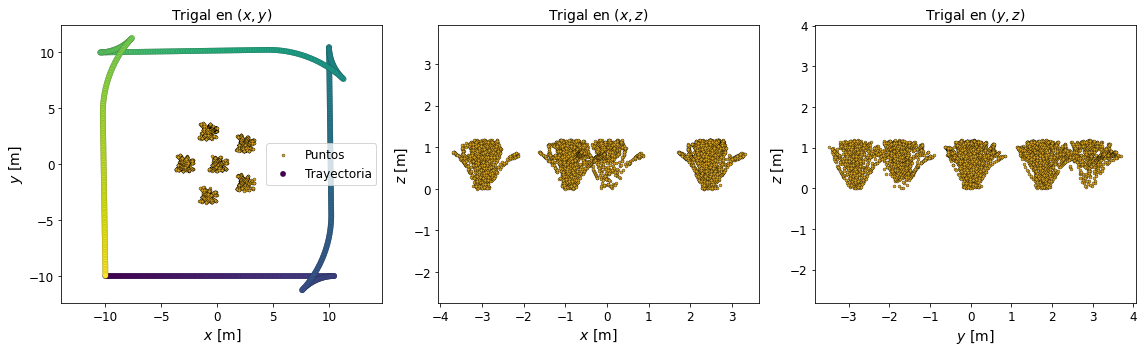

In [5]:
# Graficar resultado de la simulación
Ptrigo = P[P[:, 14] > 0]
fig = plt.figure(figsize=(16, 5))
# Graficar trigo en (x, y)
ax = fig.add_subplot(1, 3, 1)
ax.scatter(
    Ptrigo[:, 0], Ptrigo[:, 1], c='goldenrod', s=9,
    edgecolor='black', linewidths=0.3, label='Puntos'
)
ax.scatter(
    T[:, 0], T[:, 1], c=T[:, 3], s=32, cmap='viridis',
    edgecolor='black', linewidths=0.1, label='Trayectoria'
)
ax.set_xlabel('$x$ [m]', fontsize=14)
ax.set_ylabel('$y$ [m]', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_title('Trigal en $(x, y)$', fontsize=14)
ax.axis('equal')
ax.legend(loc='best', fontsize=12)
# Graficar trigo en (x, z)
ax = fig.add_subplot(1, 3, 2)
ax.scatter(Ptrigo[:, 0], Ptrigo[:, 2], c='goldenrod', s=9, edgecolor='black', linewidths=0.3)
ax.set_xlabel('$x$ [m]', fontsize=14)
ax.set_ylabel('$z$ [m]', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_title('Trigal en $(x, z)$', fontsize=14)
ax.axis('equal')
# Graficar trigo en (y, z)
ax = fig.add_subplot(1, 3, 3)
ax.scatter(Ptrigo[:, 1], Ptrigo[:, 2], c='goldenrod', s=9, edgecolor='black', linewidths=0.3)
ax.set_xlabel('$y$ [m]', fontsize=14)
ax.set_ylabel('$z$ [m]', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_title('Trigal en $(y, z)$', fontsize=14)
ax.axis('equal')
# Mostrar gráfico
fig.tight_layout()
plt.show()

### Ejercicio 1

Generar una escena con una planta de trigo en el punto $(0, 0)$ y tres circunferencias de plantas de trigo con radio $r \in \left\{3, 6, 9\right\}$ metros. Aplicar ruido normal bidimensional sobre las coordenadas $(x, y)$ de cada planta de trigo con una desviación $\sigma = r/33$. La primera circunferencia debe tener $5$ plantas de trigo, la segunda $11$ y la tercera $33$. La plataforma debe moverse por las aristas del rectángulo con vértice mínimo $(-12, -12)$ y vértice máximo $(12, 12)$.

In [6]:
# TODO : Codifíquese aquí la respuesta al Ejercicio 1

### Ejercicio 2

Generar una escena con $6 \times 6$ plantas de trigo linealmente espaciadas a lo largo y ancho del rectángulo con vértice mínimo $(-10, -10)$ y vértice máximo $(10, 10)$. Cada planta debe escalarse por un factor $2.5 \pm X \sim \mathcal{N}(\mu=0, \sigma=0.3)$. Cada planta debe estar rotada por un ángulo (en grados) tomado aleatoriamente de una distribución uniforme en el intervalo $[0, 360)$. Además, la posición linealmente espaciada de las plantas debe modificarse con un desplazamiento aleatorio basado en una distribución normal $\mathcal{N}(\mu=0, \sigma=0.2)$.

La trayectoria del tractor usado para escanear el trigal debe componerse de cuatro etapas lineales, cada una recorriendo una de las aristas del rectángulo con vértice mínimo $(-12.5, -12.5)$ y vértice máximo $(12.5, 12.5)$. El tractor debe moverse a una velocidad de $20\;\mathrm{km}/\mathrm{h}$.

In [7]:
# TODO : Codifíquese aquí la respuesta al Ejercicio 2

### Solución : Ejercicio 1

In [8]:
# Ruta al directorio temporal donde se exportarán los XML
tmpdir = os.path.join(os.getcwd(), 'tmpdir')
tmp_scene_xml = os.path.join(tmpdir, 'scene.xml')
tmp_survey_xml = os.path.join(tmpdir, 'survey.xml')
# XML de escena
SCENE_XML = \
'''
<?xml version="1.0" encoding="UTF-8"?>
<document>
<scene id="scene" name="scene">
    <part>
        <filter type="objloader">
            <param type="string" key="filepath" value="helios_asset/sceneparts/groundplane.obj" />
        </filter>
        <filter type="scale">
            <param type="double" key="scale" value="25" />
        </filter>
    </part>
<<<PARTES>>>
</scene>
</document>
'''
# XML de simulación
SURVEY_XML = \
f'''
<?xml version="1.0" encoding="UTF-8"?>
<document>
<survey name="trigal_procedimental" scene="{tmp_scene_xml}#scene" platform="helios_asset/platforms.xml#tractor" scanner="helios_asset/scanners_tls.xml#riegl_vz400">
    <leg>
        <platformSettings  x="-12" y="-12" z="0" onGround="true" movePerSec_m="3"/>
        <scannerSettings  active="true" pulseFreq_hz="100000" scanAngle_deg="20" scanFreq_hz="50" headRotatePerSec_deg="0.00" headRotateStart_deg="0.00" headRotateStop_deg="0.00" trajectoryTimeInterval_s="0.05"/>
    </leg>

    <leg>
        <platformSettings  x="12" y="-12" z="0" onGround="true" movePerSec_m="3"/>
        <scannerSettings  active="true" pulseFreq_hz="100000" scanAngle_deg="20" scanFreq_hz="50" headRotatePerSec_deg="0.00" headRotateStart_deg="0.00" headRotateStop_deg="0.00" trajectoryTimeInterval_s="0.05"/>
    </leg>

    <leg>
        <platformSettings  x="12" y="12" z="0" onGround="true" movePerSec_m="3"/>
        <scannerSettings  active="true" pulseFreq_hz="100000" scanAngle_deg="20" scanFreq_hz="50" headRotatePerSec_deg="0.00" headRotateStart_deg="0.00" headRotateStop_deg="0.00" trajectoryTimeInterval_s="0.05"/>
    </leg>

    <leg>
        <platformSettings  x="-12" y="12" z="0" onGround="true" movePerSec_m="3"/>
        <scannerSettings  active="true" pulseFreq_hz="100000" scanAngle_deg="20" scanFreq_hz="50" headRotatePerSec_deg="0.00" headRotateStart_deg="0.00" headRotateStop_deg="0.00" trajectoryTimeInterval_s="0.05"/>
    </leg>

    <leg>
        <platformSettings  x="-12" y="-12" z="0" onGround="true" movePerSec_m="3"/>
        <scannerSettings  active="false" pulseFreq_hz="100000" scanAngle_deg="20" scanFreq_hz="50" headRotatePerSec_deg="0.00" headRotateStart_deg="0.00" headRotateStop_deg="0.00" trajectoryTimeInterval_s="0.05"/>
    </leg>
</survey>
</document>
'''

In [9]:
# Generar plantas de trigo concéntricas
partes_xml = \
'''        <part>
            <filter type="objloader">
                <param type="string" key="filepath" value="helios_asset/sceneparts/wheat.obj" />
            </filter>
            <filter type="rotate">
                <param type="rotation" key="rotation">
                    <rot axis="x" angle_deg="90" />
                </param>
            </filter>
            <filter type="scale">
                <param type="double" key="scale" value="2" />
            </filter>
        </part>
'''
r = [3, 6, 9]  # Radios
m = [5, 11, 33]  # Numero de plantas
for mi, ri in zip(m, r):
    theta = np.linspace(-np.pi, np.pi, mi, endpoint=False)
    N = np.random.normal(0, ri/33.0, (mi, 2))
    for Ni, thetai in zip(N, theta):
        x = ri*np.cos(thetai)+Ni[0]
        y = ri*np.sin(thetai)+Ni[1]
        partes_xml += \
f'''        <part>
            <filter type="objloader">
                <param type="string" key="filepath" value="helios_asset/sceneparts/wheat.obj" />
            </filter>
            <filter type="rotate">
                <param type="rotation" key="rotation">
                    <rot axis="x" angle_deg="90" />
                </param>
            </filter>
            <filter type="scale">
                <param type="double" key="scale" value="2" />
            </filter>
            <filter type="translate">
                <param type="vec3" key="offset" value="{x:.3f};{y:.3f};0" />
            </filter>
        </part>
'''

# Actualizar XML de escena con las partes generadas procedimentalmente
SCENE_XML = SCENE_XML.replace('<<<PARTES>>>', partes_xml)

# Escribir XMLs
os.makedirs(tmpdir, exist_ok=True)
with open(tmp_scene_xml, 'w') as scene_file:
    scene_file.write(SCENE_XML)
with open(tmp_survey_xml, 'w') as survey_file:
    survey_file.write(SURVEY_XML)

In [10]:
# Cargar simulación
root_dir = os.getcwd()
out_dir = os.path.join(root_dir, 'output/pyhelios/procedimental')
sim_builder = pyhelios.SimulationBuilder(
    tmp_survey_xml,
    os.path.join(root_dir, 'helios_asset/'),
    out_dir
)
print(f'Cargada simulacion desde: "{tmp_survey_xml}"')

# Configurar las nubes sintéticas para que tengan formato LAZ (LAS comprimido)
sim_builder.setLasOutput(True)
sim_builder.setZipOutput(True)

# Construir la simulación
sim = sim_builder.build()

# Ejecutar la simulación
start = time.perf_counter()
sim.start()
out = sim.join()
end = time.perf_counter()
print(f'La simulación se ha ejecutado en {end-start:.3f} segundos.')

# Extraer información de interés
P, T = pyhelios.outputToNumpy(out)

surveyPath: "/home/uadmin/git/vlsdl_workshop2024/tmpdir/survey.xml"
Cargada simulacion desde: "/home/uadmin/git/vlsdl_workshop2024/tmpdir/survey.xml"
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 40.498150947001704 seconds
La simulación se ha ejecutado en 1.241 segundos.


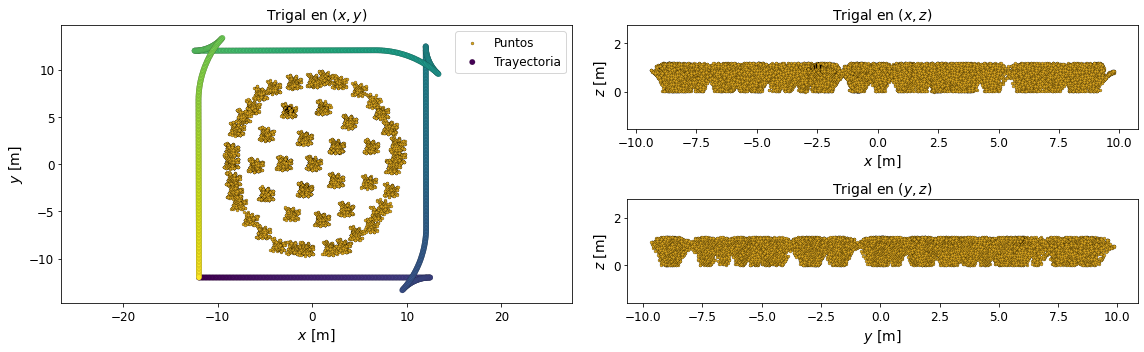

In [11]:
# Graficar resultado de la simulación
Ptrigo = P[P[:, 14] > 0]
fig = plt.figure(figsize=(16, 5))
# Graficar trigo en (x, y)
ax = fig.add_subplot(1, 2, 1)
ax.scatter(
    Ptrigo[:, 0], Ptrigo[:, 1], c='goldenrod', s=9,
    edgecolor='black', linewidths=0.2, label='Puntos'
)
ax.scatter(
    T[:, 0], T[:, 1], c=T[:, 3], s=32, cmap='viridis',
    edgecolor='black', linewidths=0.1, label='Trayectoria'
)
ax.set_xlabel('$x$ [m]', fontsize=14)
ax.set_ylabel('$y$ [m]', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_title('Trigal en $(x, y)$', fontsize=14)
ax.axis('equal')
ax.legend(loc='best', fontsize=12)
# Graficar trigo en (x, z)
ax = fig.add_subplot(2, 2, 2)
ax.scatter(Ptrigo[:, 0], Ptrigo[:, 2], c='goldenrod', s=9, edgecolor='black', linewidths=0.2)
ax.set_xlabel('$x$ [m]', fontsize=14)
ax.set_ylabel('$z$ [m]', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_title('Trigal en $(x, z)$', fontsize=14)
ax.axis('equal')
# Graficar trigo en (y, z)
ax = fig.add_subplot(2, 2, 4)
ax.scatter(Ptrigo[:, 1], Ptrigo[:, 2], c='goldenrod', s=9, edgecolor='black', linewidths=0.2)
ax.set_xlabel('$y$ [m]', fontsize=14)
ax.set_ylabel('$z$ [m]', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_title('Trigal en $(y, z)$', fontsize=14)
ax.axis('equal')
# Mostrar gráfico
fig.tight_layout()
plt.show()

### Solución : Ejercicio 2

In [12]:
# Ruta al directorio temporal donde se exportarán los XML
tmpdir = os.path.join(os.getcwd(), 'tmpdir')
tmp_scene_xml = os.path.join(tmpdir, 'scene.xml')
tmp_survey_xml = os.path.join(tmpdir, 'survey.xml')
# XML de escena
SCENE_XML = \
'''
<?xml version="1.0" encoding="UTF-8"?>
<document>
<scene id="scene" name="scene">
    <part>
        <filter type="objloader">
            <param type="string" key="filepath" value="helios_asset/sceneparts/groundplane.obj" />
        </filter>
        <filter type="scale">
            <param type="double" key="scale" value="15" />
        </filter>
    </part>
<<<PARTES>>>
</scene>
</document>
'''
# XML de simulación
SURVEY_XML = \
f'''
<?xml version="1.0" encoding="UTF-8"?>
<document>
<survey name="trigal_procedimental" scene="{tmp_scene_xml}#scene" platform="helios_asset/platforms.xml#tractor" scanner="helios_asset/scanners_tls.xml#riegl_vz400">
    <leg>
        <platformSettings  x="-12.5" y="-12.5" z="0" onGround="true" movePerSec_m="5.55556"/>
        <scannerSettings  active="true" pulseFreq_hz="100000" scanAngle_deg="20" scanFreq_hz="50" headRotatePerSec_deg="0.00" headRotateStart_deg="0.00" headRotateStop_deg="0.00" trajectoryTimeInterval_s="0.05"/>
    </leg>

    <leg>
        <platformSettings  x="12.5" y="-12.5" z="0" onGround="true" movePerSec_m="5.55556"/>
        <scannerSettings  active="true" pulseFreq_hz="100000" scanAngle_deg="20" scanFreq_hz="50" headRotatePerSec_deg="0.00" headRotateStart_deg="0.00" headRotateStop_deg="0.00" trajectoryTimeInterval_s="0.05"/>
    </leg>

    <leg>
        <platformSettings  x="12.5" y="12.5" z="0" onGround="true" movePerSec_m="5.55556"/>
        <scannerSettings  active="true" pulseFreq_hz="100000" scanAngle_deg="20" scanFreq_hz="50" headRotatePerSec_deg="0.00" headRotateStart_deg="0.00" headRotateStop_deg="0.00" trajectoryTimeInterval_s="0.05"/>
    </leg>

    <leg>
        <platformSettings  x="-12.5" y="12.5" z="0" onGround="true" movePerSec_m="5.55556"/>
        <scannerSettings  active="true" pulseFreq_hz="100000" scanAngle_deg="20" scanFreq_hz="50" headRotatePerSec_deg="0.00" headRotateStart_deg="0.00" headRotateStop_deg="0.00" trajectoryTimeInterval_s="0.05"/>
    </leg>

    <leg>
        <platformSettings  x="-12.5" y="-12.5" z="0" onGround="true" movePerSec_m="5.55556"/>
        <scannerSettings  active="false" pulseFreq_hz="100000" scanAngle_deg="20" scanFreq_hz="50" headRotatePerSec_deg="0.00" headRotateStart_deg="0.00" headRotateStop_deg="0.00" trajectoryTimeInterval_s="0.05"/>
    </leg>
</survey>
</document>
'''

In [13]:
# Generar trigal rectangular
partes_xml = ''
t = np.linspace(-10, 10, 6)
Noffset = np.random.normal(0, 0.2, (t.shape[0]**2, 2))
Nscale = np.random.normal(0, 0.3, t.shape[0]**2)
Uangle = np.random.uniform(0, 360, t.shape[0]**2)
i=0
for tx in t:
    for ty in t:
        scale_factor = 2.5 + Nscale[i]
        x = tx + Noffset[i][0]
        y = ty + Noffset[i][1]
        angle = Uangle[i]
        partes_xml += \
f'''        <part>
            <filter type="objloader">
                <param type="string" key="filepath" value="helios_asset/sceneparts/wheat.obj" />
            </filter>
            <filter type="rotate">
                <param type="rotation" key="rotation">
                    <rot axis="x" angle_deg="90" />
                    <rot axis="z" angle_deg="{angle:.3f}" />
                </param>
            </filter>
            <filter type="scale">
                <param type="double" key="scale" value="{scale_factor:.3f}" />
            </filter>
            <filter type="translate">
                <param type="vec3" key="offset" value="{x:.3f};{y:.3f};0" />
            </filter>
        </part>
'''
        i += 1

# Actualizar XML de escena con las partes generadas procedimentalmente
SCENE_XML = SCENE_XML.replace('<<<PARTES>>>', partes_xml)

# Escribir XMLs
os.makedirs(tmpdir, exist_ok=True)
with open(tmp_scene_xml, 'w') as scene_file:
    scene_file.write(SCENE_XML)
with open(tmp_survey_xml, 'w') as survey_file:
    survey_file.write(SURVEY_XML)

In [14]:
# Cargar simulación
root_dir = os.getcwd()
out_dir = os.path.join(root_dir, 'output/pyhelios/procedimental')
sim_builder = pyhelios.SimulationBuilder(
    tmp_survey_xml,
    os.path.join(root_dir, 'helios_asset/'),
    out_dir
)
print(f'Cargada simulacion desde: "{tmp_survey_xml}"')

# Configurar las nubes sintéticas para que tengan formato LAZ (LAS comprimido)
sim_builder.setLasOutput(True)
sim_builder.setZipOutput(True)

# Construir la simulación
sim = sim_builder.build()

# Ejecutar la simulación
start = time.perf_counter()
sim.start()
out = sim.join()
end = time.perf_counter()
print(f'La simulación se ha ejecutado en {end-start:.3f} segundos.')

# Extraer información de interés
P, T = pyhelios.outputToNumpy(out)

surveyPath: "/home/uadmin/git/vlsdl_workshop2024/tmpdir/survey.xml"
Cargada simulacion desde: "/home/uadmin/git/vlsdl_workshop2024/tmpdir/survey.xml"
SimulationBuilder is building simulation ...
SimulationBuilder built simulation in 29.39827767799943 seconds
La simulación se ha ejecutado en 1.041 segundos.


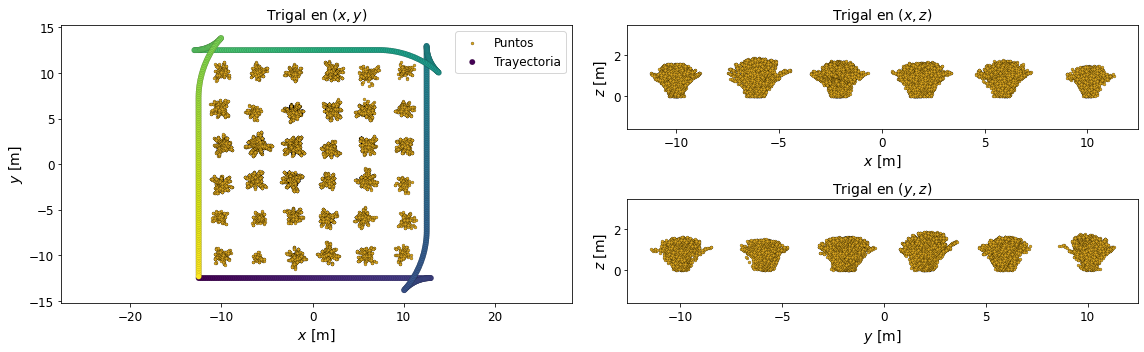

In [15]:
# Graficar resultado de la simulación
Ptrigo = P[P[:, 14] > 0]
fig = plt.figure(figsize=(16, 5))
# Graficar trigo en (x, y)
ax = fig.add_subplot(1, 2, 1)
ax.scatter(
    Ptrigo[:, 0], Ptrigo[:, 1], c='goldenrod', s=9,
    edgecolor='black', linewidths=0.2, label='Puntos'
)
ax.scatter(
    T[:, 0], T[:, 1], c=T[:, 3], s=32, cmap='viridis',
    edgecolor='black', linewidths=0.1, label='Trayectoria'
)
ax.set_xlabel('$x$ [m]', fontsize=14)
ax.set_ylabel('$y$ [m]', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_title('Trigal en $(x, y)$', fontsize=14)
ax.axis('equal')
ax.legend(loc='best', fontsize=12)
# Graficar trigo en (x, z)
ax = fig.add_subplot(2, 2, 2)
ax.scatter(Ptrigo[:, 0], Ptrigo[:, 2], c='goldenrod', s=9, edgecolor='black', linewidths=0.2)
ax.set_xlabel('$x$ [m]', fontsize=14)
ax.set_ylabel('$z$ [m]', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_title('Trigal en $(x, z)$', fontsize=14)
ax.axis('equal')
# Graficar trigo en (y, z)
ax = fig.add_subplot(2, 2, 4)
ax.scatter(Ptrigo[:, 1], Ptrigo[:, 2], c='goldenrod', s=9, edgecolor='black', linewidths=0.2)
ax.set_xlabel('$y$ [m]', fontsize=14)
ax.set_ylabel('$z$ [m]', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_title('Trigal en $(y, z)$', fontsize=14)
ax.axis('equal')
# Mostrar gráfico
fig.tight_layout()
plt.show()